In [ ]:
# Modeling exam
# Vadim Zhovtanyuk
# Cisco Systems, 2020

In [55]:
import numpy as np
import pandas as pd
import scipy.stats
import statistics as stat
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2
import sys

In [2]:
#Loading the data into pandas dataframe
file = 'dnac-customer-bookings.csv'
data = pd.read_csv(file, sep=',', header=0, parse_dates=True)

In [3]:
#First look at the data
data

,cust,segment,vertical,sub_vertical,country,bookings,purchase
0,d66648938c68318a8dad17a77f0c8327,Commercial,Manufacturing,Hi-tech/Computers Manufacturing,UNITED STATES,103356,False
1,dcce1fa11f27a6a2c57c8aacf5f0219c,Commercial,Retail,Other (Retail),UNITED STATES,62952,True
2,136b88d1b2aea8ae74cbfe111830af69,Commercial,Retail,Other (Retail),ITALY,2886,True
3,674c6fcb90b5d29765f266007ad423e1,Enterprise,Retail,Other (Retail),UNITED STATES,80253,True
4,97c72b3833ce8ef5154826fc128522b1,Commercial,Health Care,Providers,AUSTRALIA,29424,False
...,...,...,...,...,...,...,...
27338,d95a7c1779b6165d0302e8e191243239,Enterprise,Professional Services,Construction/Engineering,UNITED STATES,4142,True
27339,24113cecc9177b25a3d22c84f9d6ceec,Enterprise,Government,Federal/Central Government,CHINA,6233,False
27340,c082a0889baf15ce697b044914e3ed44,Enterprise,Manufacturing,Discrete Manufacturing,UNITED STATES,4003,False
27341,9a28b51f3f5d510a98c8b92446ea9a00,Commercial,Retail,"Consumer Services(dry cleaners,video rental,etc)",UNITED STATES,1471,True


In [4]:
#Removing cust column which is unique in each row and hence not useful for further analysis
data = data.drop("cust", axis=1)

In [5]:
#Checking if there are any "0" values
data.isnull().any()

segment         False
vertical        False
sub_vertical    False
country         False
bookings        False
purchase        False
dtype: bool

In [6]:
#Checking "segment" column
data["segment"].value_counts()

Enterprise             16623
Commercial             10471
commercial               246
enterprise                 2
enterprise customer        1
Name: segment, dtype: int64

In [7]:
#Fixing different names for the same segment
def fix(column):
    results = {}
    results['column'] = column.name

    #Replacing the "wrong" names
    segment_column = []
    for value in column:
        if value == "enterprise customer":
            segment_column.append("Enterprise")
        elif value == "enterprise":
            segment_column.append("Enterprise")
        elif value == "commercial":
            segment_column.append("Commercial")
        else:
            segment_column.append(value)

    #Creating new column data with 'fixed' entries
    results['data'] = segment_column

    return results

#Replacing data with new value
missing_data = data.apply(fix)
for m in missing_data:
    data[m['column']] = m['data']

In [8]:
#Verification of segment name
data["segment"].value_counts()

Enterprise    16626
Commercial    10717
Name: segment, dtype: int64

In [9]:
#Encoding segment column to prepare data for further analysis 
data["segment"] = data["segment"].astype("category")
segment_encode = LabelEncoder()
data["segment"] = segment_encode.fit_transform(data.segment)
segment_one_hot = OneHotEncoder()
segment_one_hot_encode = segment_one_hot.fit_transform(data.segment.values.reshape(-1,1)).toarray()
ohe_variable = pd.DataFrame(segment_one_hot_encode, columns = ["segment_" + str(int(i)) for i in range (segment_one_hot_encode.shape[1])])
data = pd.concat([data, ohe_variable], axis=1)
data = data.drop("segment", axis=1)

In [10]:
data

,vertical,sub_vertical,country,bookings,purchase,segment_0,segment_1
0,Manufacturing,Hi-tech/Computers Manufacturing,UNITED STATES,103356,False,1.0,0.0
1,Retail,Other (Retail),UNITED STATES,62952,True,1.0,0.0
2,Retail,Other (Retail),ITALY,2886,True,1.0,0.0
3,Retail,Other (Retail),UNITED STATES,80253,True,0.0,1.0
4,Health Care,Providers,AUSTRALIA,29424,False,1.0,0.0
...,...,...,...,...,...,...,...
27338,Professional Services,Construction/Engineering,UNITED STATES,4142,True,0.0,1.0
27339,Government,Federal/Central Government,CHINA,6233,False,0.0,1.0
27340,Manufacturing,Discrete Manufacturing,UNITED STATES,4003,False,0.0,1.0
27341,Retail,"Consumer Services(dry cleaners,video rental,etc)",UNITED STATES,1471,True,1.0,0.0


In [11]:
#Checking "vertical" column
data["vertical"].value_counts()

Professional Services     5553
Manufacturing             5112
Government                3559
Retail                    3483
Technical Services        2816
Financial Services        2573
Wholesale/Distribution    2384
Health Care               1863
Name: vertical, dtype: int64

In [12]:
#Encoding "vertical" column to prepare data for further analysis 
data["vertical"] = data["vertical"].astype("category")
vertical_encode = LabelEncoder()
data["vertical"] = vertical_encode.fit_transform(data.vertical)
vertical_one_hot = OneHotEncoder()
vertical_one_hot_encode = vertical_one_hot.fit_transform(data.vertical.values.reshape(-1,1)).toarray()
ohe_variable = pd.DataFrame(vertical_one_hot_encode, columns = ["vertical_" + str(int(i)) for i in range (vertical_one_hot_encode.shape[1])])
data = pd.concat([data, ohe_variable], axis=1)
data = data.drop("vertical", axis=1)

In [13]:
data

,sub_vertical,country,bookings,purchase,segment_0,segment_1,vertical_0,vertical_1,vertical_2,vertical_3,vertical_4,vertical_5,vertical_6,vertical_7
0,Hi-tech/Computers Manufacturing,UNITED STATES,103356,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Other (Retail),UNITED STATES,62952,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Other (Retail),ITALY,2886,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Other (Retail),UNITED STATES,80253,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Providers,AUSTRALIA,29424,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,Construction/Engineering,UNITED STATES,4142,True,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27339,Federal/Central Government,CHINA,6233,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
27340,Discrete Manufacturing,UNITED STATES,4003,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27341,"Consumer Services(dry cleaners,video rental,etc)",UNITED STATES,1471,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
#Checking "sub_vertical" column
data["sub_vertical"].value_counts()

Federal/Central Government                          3559
Other (Technical Services)                          2816
Other (Credit Card, mortgage, financing, etc.)      2573
Other (Retail)                                      2472
Wholesale/Distribution                              2384
Other (Professional Services)                       1908
Providers                                           1863
Discrete Manufacturing                              1834
Consumer Products Manufacturing                     1703
Hi-tech/Computers Manufacturing                     1575
Consulting Non-Technical                            1125
Construction/Engineering                            1013
Consumer Services(dry cleaners,video rental,etc)    1011
Real Estate                                          785
Membership organizations                             722
Name: sub_vertical, dtype: int64

In [15]:
#Encoding "sub_vertical" column to prepare data for further analysis 
data["sub_vertical"] = data["sub_vertical"].astype("category")
sub_vertical_encode = LabelEncoder()
data["sub_vertical"] = sub_vertical_encode.fit_transform(data.sub_vertical)
sub_vertical_one_hot = OneHotEncoder()
sub_vertical_one_hot_encode = sub_vertical_one_hot.fit_transform(data.sub_vertical.values.reshape(-1,1)).toarray()
ohe_variable = pd.DataFrame(sub_vertical_one_hot_encode, columns = ["sub_vertical_" + str(int(i)) for i in range (sub_vertical_one_hot_encode.shape[1])])
data = pd.concat([data, ohe_variable], axis=1)
data = data.drop("sub_vertical", axis=1)

In [16]:
data

,country,bookings,purchase,segment_0,segment_1,vertical_0,vertical_1,vertical_2,vertical_3,vertical_4,...,sub_vertical_5,sub_vertical_6,sub_vertical_7,sub_vertical_8,sub_vertical_9,sub_vertical_10,sub_vertical_11,sub_vertical_12,sub_vertical_13,sub_vertical_14
0,UNITED STATES,103356,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,UNITED STATES,62952,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ITALY,2886,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,UNITED STATES,80253,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,AUSTRALIA,29424,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,UNITED STATES,4142,True,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27339,CHINA,6233,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27340,UNITED STATES,4003,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27341,UNITED STATES,1471,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#Checking "country" column
data["country"].value_counts()

UNITED STATES     13810
UNITED KINGDOM     2246
CHINA              1836
GERMANY            1683
CANADA             1277
JAPAN              1228
AUSTRALIA          1183
FRANCE              983
ITALY               787
MEXICO              733
INDIA               705
BRAZIL              451
USA                 347
DEUTSCHLAND          74
Name: country, dtype: int64

In [18]:
#Fixing different names for the same country issues
def fix(column):
    results = {}
    results['column'] = column.name

    #Replacing different names for the same country
    country_column = []
    for value in column:
        if value == "USA":
            country_column.append("UNITED STATES")
        elif value == "DEUTSCHLAND":
            country_column.append("GERMANY")
        else:
            country_column.append(value)

    #Creating new column data with 'fixed' entries
    results['data'] = country_column

    return results  

#Replacing data with new value
temp_data = data.apply(fix)
for m in temp_data:
    data[m['column']] = m['data']

In [19]:
#Verification of country names
data["country"].value_counts()

UNITED STATES     14157
UNITED KINGDOM     2246
CHINA              1836
GERMANY            1757
CANADA             1277
JAPAN              1228
AUSTRALIA          1183
FRANCE              983
ITALY               787
MEXICO              733
INDIA               705
BRAZIL              451
Name: country, dtype: int64

In [20]:
#Encoding "country" column to prepare data for further analysis 
data["country"] = data["country"].astype("category")
country_encode = LabelEncoder()
data["country"] = country_encode.fit_transform(data.country)
country_one_hot = OneHotEncoder()
country_one_hot_encode = country_one_hot.fit_transform(data.country.values.reshape(-1,1)).toarray()
ohe_variable = pd.DataFrame(country_one_hot_encode, columns = ["country_" + str(int(i)) for i in range (country_one_hot_encode.shape[1])])
data = pd.concat([data, ohe_variable], axis=1)
data = data.drop("country", axis=1)

In [21]:
data

,bookings,purchase,segment_0,segment_1,vertical_0,vertical_1,vertical_2,vertical_3,vertical_4,vertical_5,...,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,country_10,country_11
0,103356,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,62952,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2886,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,80253,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,29424,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,4142,True,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27339,6233,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27340,4003,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27341,1471,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
#Checking "bookings"
data["bookings"].value_counts()

unknown    73
2406        8
2272        7
2028        7
1795        7
           ..
37895       1
63815       1
671176      1
4326        1
39758       1
Name: bookings, Length: 22474, dtype: int64

In [25]:
#Replacing "unknown" and negative values with pre-defined value "1010101"
def fix(column):
    results = {}
    results['column'] = column.name

    fix_column = []
    for value in column:
        if value == "unknown":
            fix_column.append("1010101")
        elif str(value).startswith("-"):
            fix_column.append("1010101")
        else:
            fix_column.append(value)

    #Creating new column data with 'fixed' entries
    results['data'] = fix_column

    return results  

#Replacing data with new value
temp_data = data.apply(fix)
for m in temp_data:
    data[m['column']] = m['data']

In [26]:
#Verification of bookings values
data["bookings"].value_counts()

1010101    75
2406        8
1795        7
2272        7
1476        7
           ..
77960       1
37895       1
63815       1
671176      1
39758       1
Name: bookings, Length: 22472, dtype: int64

In [27]:
#Fixing wrong data in bookings 
def missing(column):
    results = {}
    results['column'] = column.name

    #Step1 -  Removing wrong entries and calcualting median 
    s1_column = [x for x in column if x != 1010101]
    results['removed_median'] = stat.median(s1_column)
    
    #Step2 - Replace wrong entries with (removed) median
    s2_column = []
    for value in column:
        if value != 1010101:
            s2_column.append(value)
        else:
            s2_column.append(results['removed_median'])

    #Creating new column data with 'fixed' entries
    results['data'] = s2_column

    return results

#Replace missing data with mean value
ds = data.astype({'bookings': 'int64'})
missing_data = ds.select_dtypes(include=['float64', 'int64']).apply(missing)
for m in missing_data:
    ds[m['column']] = m['data']  
    
data = ds.astype({'bookings': 'int64'})    

In [28]:
data

,bookings,purchase,segment_0,segment_1,vertical_0,vertical_1,vertical_2,vertical_3,vertical_4,vertical_5,...,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,country_10,country_11
0,103356,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,62952,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2886,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,80253,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,29424,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,4142,True,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27339,6233,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27340,4003,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27341,1471,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
#Encoding "purchase" column to prepare data for further analysis 
data["purchase"] = data["purchase"].astype("category")
purchase_encode = LabelEncoder()
data["purchase"] = purchase_encode.fit_transform(data.purchase)
purchase_one_hot = OneHotEncoder()
purchase_one_hot_encode = purchase_one_hot.fit_transform(data.purchase.values.reshape(-1,1)).toarray()
ohe_variable = pd.DataFrame(purchase_one_hot_encode, columns = ["purchase_" + str(int(i)) for i in range (purchase_one_hot_encode.shape[1])])
data = pd.concat([data, ohe_variable], axis=1)
data = data.drop("purchase", axis=1)

In [65]:
data

,bookings,segment_0,segment_1,vertical_0,vertical_1,vertical_2,vertical_3,vertical_4,vertical_5,vertical_6,...,country_6,country_7,country_8,country_9,country_10,country_11,purchase_0,purchase_1,purchase_0,purchase_1
0,103356,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,62952,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,2886,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,80253,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,29424,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,4142,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
27339,6233,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
27340,4003,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
27341,1471,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [29]:
data.describe()

,bookings,segment_0,segment_1,vertical_0,vertical_1,vertical_2,vertical_3,vertical_4,vertical_5,vertical_6,...,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,country_10,country_11
count,2.734300e+04,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,...,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000
mean,1.676273e+05,0.391947,0.608053,0.094101,0.130161,0.068134,0.186958,0.203087,0.127382,0.102988,...,0.046703,0.067147,0.035951,0.064258,0.025784,0.028783,0.044911,0.026808,0.082142,0.517756
std,1.113539e+06,0.488194,0.488194,0.291974,0.336487,0.251981,0.389885,0.402304,0.333406,0.303949,...,0.211006,0.250281,0.186171,0.245216,0.158492,0.167198,0.207112,0.161524,0.274585,0.499694
min,1.010000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.782000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.309500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8.516950e+04,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.001464e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
data.shape

(27343, 39)

In [31]:
data.dtypes

bookings             int64
purchase              bool
segment_0          float64
segment_1          float64
vertical_0         float64
vertical_1         float64
vertical_2         float64
vertical_3         float64
vertical_4         float64
vertical_5         float64
vertical_6         float64
vertical_7         float64
sub_vertical_0     float64
sub_vertical_1     float64
sub_vertical_2     float64
sub_vertical_3     float64
sub_vertical_4     float64
sub_vertical_5     float64
sub_vertical_6     float64
sub_vertical_7     float64
sub_vertical_8     float64
sub_vertical_9     float64
sub_vertical_10    float64
sub_vertical_11    float64
sub_vertical_12    float64
sub_vertical_13    float64
sub_vertical_14    float64
country_0          float64
country_1          float64
country_2          float64
country_3          float64
country_4          float64
country_5          float64
country_6          float64
country_7          float64
country_8          float64
country_9          float64
c

In [32]:
data.groupby("purchase").size()

purchase
False    17743
True      9600
dtype: int64

In [33]:
data.corr(method='pearson')

,bookings,purchase,segment_0,segment_1,vertical_0,vertical_1,vertical_2,vertical_3,vertical_4,vertical_5,...,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,country_10,country_11
bookings,1.000000,-0.002969,0.002394,-0.002394,0.005144,0.006878,0.005686,-0.008447,-0.003066,-0.001976,...,0.014700,-0.003880,-0.000859,-0.004583,-0.005735,-0.001598,0.007075,-0.001557,0.000307,0.001626
purchase,-0.002969,1.000000,-0.001364,0.001364,0.005152,-0.071627,0.016089,-0.002319,0.007307,-0.006404,...,-0.007752,-0.054988,-0.009518,-0.016522,-0.011372,-0.009767,-0.018182,-0.013450,0.007378,0.066939
segment_0,0.002394,-0.001364,1.000000,-1.000000,-0.077355,-0.291649,0.022834,-0.074484,0.132498,0.071646,...,0.018634,-0.160924,-0.026271,0.028519,-0.033713,0.031158,-0.050391,-0.045591,-0.001449,0.088037
segment_1,-0.002394,0.001364,-1.000000,1.000000,0.077355,0.291649,-0.022834,0.074484,-0.132498,-0.071646,...,-0.018634,0.160924,0.026271,-0.028519,0.033713,-0.031158,0.050391,0.045591,0.001449,-0.088037
vertical_0,0.005144,0.005152,-0.077355,0.077355,1.000000,-0.124675,-0.087149,-0.154551,-0.162702,-0.123140,...,-0.003067,-0.038422,0.052145,0.020262,0.006053,0.042661,-0.031182,0.022509,0.057320,-0.071491
vertical_1,0.006878,-0.071627,-0.291649,0.291649,-0.124675,1.000000,-0.104599,-0.185497,-0.195280,-0.147796,...,-0.013504,0.358729,-0.041422,-0.064136,0.000162,0.022469,0.017928,0.051540,-0.066241,-0.089334
vertical_2,0.005686,0.016089,0.022834,-0.022834,-0.087149,-0.104599,1.000000,-0.129665,-0.136503,-0.103311,...,-0.019266,-0.070226,-0.024150,-0.021730,-0.034832,-0.034396,-0.027800,-0.039487,-0.034903,0.136933
vertical_3,-0.008447,-0.002319,-0.074484,0.074484,-0.154551,-0.185497,-0.129665,1.000000,-0.242076,-0.183213,...,-0.007000,0.006651,-0.002912,0.023150,0.042730,0.025732,0.058163,0.015076,-0.008509,-0.057964
vertical_4,-0.003066,0.007307,0.132498,-0.132498,-0.162702,-0.195280,-0.136503,-0.242076,1.000000,-0.192875,...,-0.000578,-0.090397,0.028989,0.024163,-0.017309,-0.000451,-0.038360,-0.038195,0.030416,0.038188
vertical_5,-0.001976,-0.006404,0.071646,-0.071646,-0.123140,-0.147796,-0.103311,-0.183213,-0.192875,1.000000,...,0.016290,-0.087165,-0.014858,-0.032124,-0.046929,-0.027063,-0.027767,0.000427,-0.000439,0.082467


In [34]:
data.skew()

bookings           49.687189
purchase            0.623963
segment_0           0.442698
segment_1          -0.442698
vertical_0          2.780579
vertical_1          2.198396
vertical_2          3.428013
vertical_3          1.605933
vertical_4          1.476173
vertical_5          2.235384
vertical_6          2.612553
vertical_7          2.926745
sub_vertical_0      4.902368
sub_vertical_1      4.620621
sub_vertical_2      3.622657
sub_vertical_3      4.907804
sub_vertical_4      3.461525
sub_vertical_5      2.198396
sub_vertical_6      3.797807
sub_vertical_7      5.907803
sub_vertical_8      2.780579
sub_vertical_9      3.377422
sub_vertical_10     2.856812
sub_vertical_11     2.612553
sub_vertical_12     3.428013
sub_vertical_13     5.644900
sub_vertical_14     2.926745
country_0           4.490067
country_1           7.592799
country_2           4.296850
country_3           3.459190
country_4           4.985568
country_5           3.554206
country_6           5.984546
country_7     

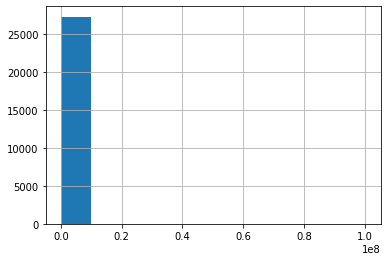

In [53]:
data["bookings"].hist()
pyplot.show()

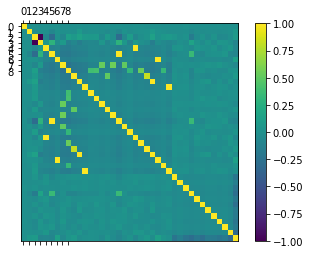

In [51]:
correlations = data.corr()
fig = pyplot.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(correlations, vmin=-1, vmax=1) 
fig.colorbar(cax) 
ticks = np.arange(0,9,1) 
ax.set_xticks(ticks) 
ax.set_yticks(ticks) 
pyplot.show()

In [67]:
array = data.values
x = array[:,0:8]
y = array[:,8] 
#feature extraction 
test = SelectKBest(score_func=chi2, k=4) 
fit = test.fit(x, y) 
# summarize scores 
fit.scores_
features = fit.transform(X) 
# summarize selected features 
features[0:5,:]

array([[103356, 0.0, 0.0, 1.0],
       [62952, 0.0, 0.0, 0.0],
       [2886, 0.0, 0.0, 0.0],
       [80253, 0.0, 0.0, 0.0],
       [29424, 0.0, 1.0, 0.0]], dtype=object)

In [68]:
data

,bookings,segment_0,segment_1,vertical_0,vertical_1,vertical_2,vertical_3,vertical_4,vertical_5,vertical_6,...,country_6,country_7,country_8,country_9,country_10,country_11,purchase_0,purchase_1,purchase_0,purchase_1
0,103356,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,62952,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,2886,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,80253,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,29424,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,4142,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
27339,6233,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
27340,4003,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
27341,1471,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
# [END]